In [1]:
# load the needed extension for the %%R cell magic
%load_ext rpy2.ipython

In [2]:
%load_ext autoreload
%autoreload 2
%load_ext rpy2.ipython
%matplotlib inline

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [3]:
import os
os.chdir('..')  # navigate to the root


In [4]:
from normal_transformers.util.util_data import pickle_load_from_file

In [5]:
from rpy2 import robjects
from rpy2.robjects import Formula, Environment
from rpy2.robjects.vectors import IntVector, FloatVector
from rpy2.robjects.lib import grid
from rpy2.robjects.packages import importr, data
from rpy2.rinterface_lib.embedded import RRuntimeError
import warnings

# The R 'print' function
rprint = robjects.globalenv.find("print")
stats = importr('stats')
grdevices = importr('grDevices')
base = importr('base')
datasets = importr('datasets')

grid.activate()

# plotting
import pandas as pd
import rpy2
import csv

from rpy2.robjects.lib import grdevices
from rpy2.robjects.vectors import IntVector, FloatVector
from IPython.display import Image, display

from rpy2.robjects import pandas2ri
pandas2ri.activate()

import rpy2.robjects as robjects
from rpy2.robjects.lib import grdevices
from rpy2.robjects.vectors import IntVector, FloatVector
from IPython.display import Image, display

import rpy2.robjects.packages as packages
import rpy2.robjects.lib.ggplot2 as ggplot2
import rpy2.robjects as ro

from rpy2.robjects.packages import STAP
with open('examples/theme_publication_tartunlp.R', 'r') as f:
    string = f.read()
pub_theme = STAP(string, "pub_theme")

/home/maksym/.conda/envs/norm/lib/python3.8/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '


In [6]:
# r_utils.install_packages("cowplot")
from pandas.api.types import CategoricalDtype

cowplot = ro.packages.importr('cowplot')

In [7]:
graphics = ro.packages.importr('graphics')
r_utils = ro.packages.importr('utils')
# r_utils.install_packages("ggthemes")
ggthemes = ro.packages.importr('ggthemes')

Golbals

# Confusion Tables

In [112]:
import itertools
domain_names = ["Europarl", "OpenSubtitles", "EMEA", "JRC-Acquis"]
clust_names = ['0', '1', '2', '3']

clus_corp_pairs = list(itertools.product(domain_names, clust_names))

In [113]:
def get_domain(fn, domain_names):
    for d in domain_names:
        if d in fn:
            return d

In [114]:
def compose_labels_pairs_dfs(bp, split="test"):
    clust_pathes = {}
    clust_pathes["nmt-sent"] = f"{bp}/nmt-clusters-sent"
    clust_pathes["nmt-doc"] = f"{bp}/nmt-clusters-doc"
    clust_pathes["bert-sent"] = f"{bp}/bert-clusters-sent"
    clust_pathes["bert-doc"] = f"{bp}/bert-clusters-doc"


    clust_fnames = {}
    for k, v in clust_pathes.items():
        clust_fnames[k] = fnames = [f for f in next(os.walk(v))[2] if split in f]

    #
    labels_pairs = {}
    for k, v in clust_fnames.items():
        clust_labels = []
        corpus_labels = []
        labels_pairs[k] = []

        for fn in v:
            d = get_domain(fn, domain_names)        

            full_fn = f"{clust_pathes[k]}/{fn}"
            with open(full_fn, "r") as f:
                curr_clust_labels = [l.strip() for l in f.readlines()]
                curr_corpus_labels = [d for i in range(len(curr_clust_labels))]
            clust_labels.extend(curr_clust_labels)
            corpus_labels.extend(curr_corpus_labels)

        labels_pairs[k] = (corpus_labels, clust_labels)

    #
    labels_pairs_dfs = {}
    for k, v in labels_pairs.items():
        print(k, len(v[0]))
        df = pd.DataFrame(
            {'corpus_label': v[0],
             'cluster_label': v[1],
            }).groupby(['corpus_label','cluster_label']).size().reset_index().rename(columns={0:'count'})
        #df['Type'] = [str(k) for i in r
        labels_pairs_dfs[k] = df
        
        
    # Fill NAs
    for k, df in labels_pairs_dfs.items():
        for p in clus_corp_pairs:
            dl, cl = p[0], p[1]
            missing = len(df[(df.corpus_label == dl) & (df.cluster_label == cl)]) == 0

            if missing:
                labels_pairs_dfs[k] = labels_pairs_dfs[k].append({'corpus_label':dl, 'cluster_label':cl, 'count':0}, ignore_index=True)

    return labels_pairs_dfs

## EN-ET

nmt-sent 12697
nmt-doc 12697
bert-sent 12697
bert-doc 12697


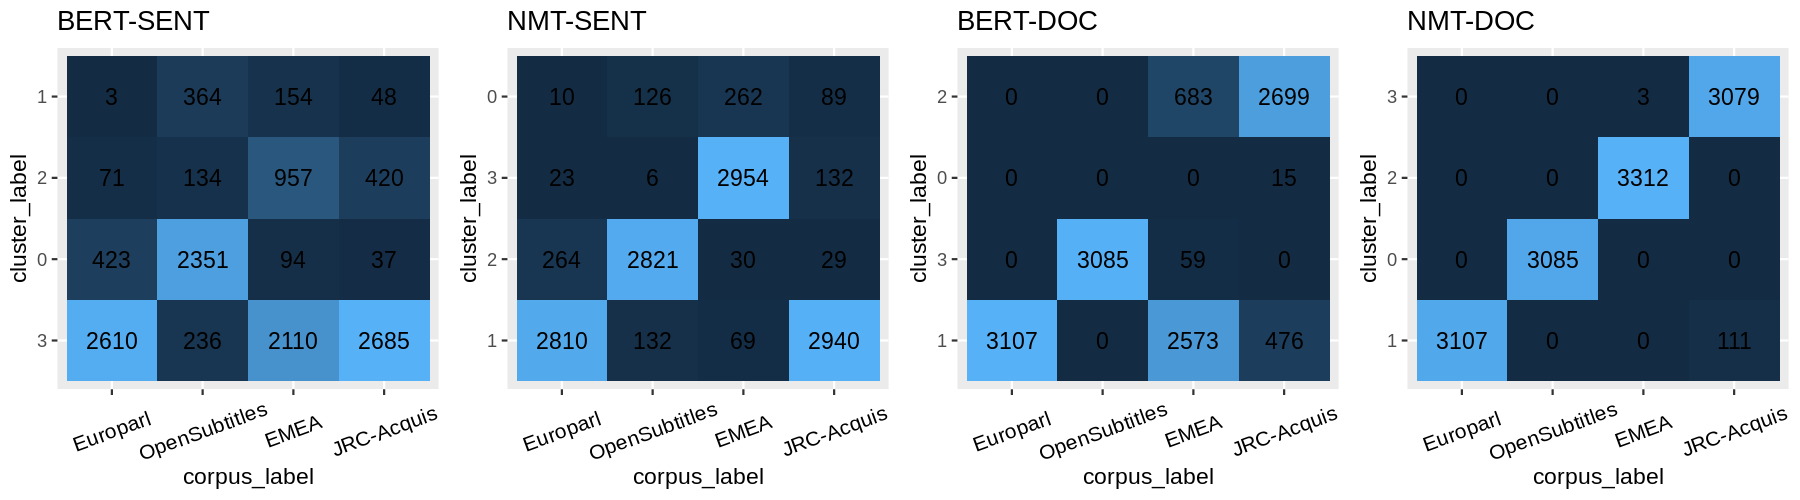

In [120]:
bp = "/home/maksym/normal-transformers/experiments/multidomain/automatic_domains/clusters-multidomain/clusters_en-et"
labels_pairs_dfs = compose_labels_pairs_dfs(bp)


# Plot
key = 'nmt-sent'

cat_clust_labels = CategoricalDtype(categories=['1', '2', '3', '0'], ordered=False)
cat_corpus_labels = CategoricalDtype(categories=['Europarl', 'OpenSubtitles', 'EMEA', 'JRC-Acquis'], ordered=False)

labels_pairs_dfs[key]['cluster_label'] = labels_pairs_dfs[key]['cluster_label'].astype(cat_clust_labels)
labels_pairs_dfs[key]['corpus_label'] = labels_pairs_dfs[key]['corpus_label'].astype(cat_corpus_labels)

# heatmap
#title = "Encoder: NMT  |  Level: sentence"#f"Interlingua at {all_interlingua_layerids} layers"
title = key.upper()
gp = ggplot2.ggplot(labels_pairs_dfs[key])
heatmap1 = gp \
+ ggplot2.aes_string(x='corpus_label', y='cluster_label', fill="count") \
+ ggplot2.ggtitle(title) \
+ ggplot2.geom_tile() \
+ ggplot2.geom_text(ggplot2.aes_string(label='count')) \
+ ggplot2.theme(legend_position = "none") +  ggplot2.theme(axis_text_x = ggplot2.element_text(angle = 20))



key = 'nmt-doc'

cat_clust_labels = CategoricalDtype(categories=['1', '0', '2', '3'], ordered=False)
cat_corpus_labels = CategoricalDtype(categories=['Europarl', 'OpenSubtitles', 'EMEA', 'JRC-Acquis'], ordered=False)

labels_pairs_dfs[key]['cluster_label'] = labels_pairs_dfs[key]['cluster_label'].astype(cat_clust_labels)
labels_pairs_dfs[key]['corpus_label'] = labels_pairs_dfs[key]['corpus_label'].astype(cat_corpus_labels)

# heatmap
#title = "Encoder: NMT  |  Level: sentence"#f"Interlingua at {all_interlingua_layerids} layers"
title = key.upper()
gp = ggplot2.ggplot(labels_pairs_dfs[key])
heatmap2 = gp \
+ ggplot2.aes_string(x='corpus_label', y='cluster_label', fill="count") \
+ ggplot2.ggtitle(title) \
+ ggplot2.geom_tile() \
+ ggplot2.geom_text(ggplot2.aes_string(label='count')) \
+ ggplot2.theme(legend_position = "none") +  ggplot2.theme(axis_text_x = ggplot2.element_text(angle = 20))


key = 'bert-sent'

cat_clust_labels = CategoricalDtype(categories=['3', '0', '2', '1'], ordered=False)
cat_corpus_labels = CategoricalDtype(categories=['Europarl', 'OpenSubtitles', 'EMEA', 'JRC-Acquis'], ordered=False)

labels_pairs_dfs[key]['cluster_label'] = labels_pairs_dfs[key]['cluster_label'].astype(cat_clust_labels)
labels_pairs_dfs[key]['corpus_label'] = labels_pairs_dfs[key]['corpus_label'].astype(cat_corpus_labels)

# heatmap
#title = "Encoder: NMT  |  Level: sentence"#f"Interlingua at {all_interlingua_layerids} layers"
title = key.upper()
gp = ggplot2.ggplot(labels_pairs_dfs[key])
heatmap3 = gp \
+ ggplot2.aes_string(x='corpus_label', y='cluster_label', fill="count") \
+ ggplot2.ggtitle(title) \
+ ggplot2.geom_tile() \
+ ggplot2.geom_text(ggplot2.aes_string(label='count')) \
+ ggplot2.theme(legend_position = "none") +  ggplot2.theme(axis_text_x = ggplot2.element_text(angle = 20))


key = 'bert-doc'

cat_clust_labels = CategoricalDtype(categories=['1', '3', '0', '2'], ordered=False)
cat_corpus_labels = CategoricalDtype(categories=['Europarl', 'OpenSubtitles', 'EMEA', 'JRC-Acquis'], ordered=False)

labels_pairs_dfs[key]['cluster_label'] = labels_pairs_dfs[key]['cluster_label'].astype(cat_clust_labels)
labels_pairs_dfs[key]['corpus_label'] = labels_pairs_dfs[key]['corpus_label'].astype(cat_corpus_labels)

# heatmap
#title = "Encoder: NMT  |  Level: sentence"#f"Interlingua at {all_interlingua_layerids} layers"
title = key.upper()
gp = ggplot2.ggplot(labels_pairs_dfs[key])
heatmap4 = gp \
+ ggplot2.aes_string(x='corpus_label', y='cluster_label', fill="count") \
+ ggplot2.ggtitle(title) \
+ ggplot2.geom_tile() \
+ ggplot2.geom_text(ggplot2.aes_string(label='count')) \
+ ggplot2.theme(legend_position = "none") +  ggplot2.theme(axis_text_x = ggplot2.element_text(angle = 20))





with grdevices.render_to_bytesio(grdevices.png, width=1800, height=500, res=150) as img:
    pp = cowplot.plot_grid(heatmap3, heatmap1, heatmap4, heatmap2, rows=1)
    pp.plot() 
display(Image(data=img.getvalue(), format='png', embed=True))

## DE-EN

nmt-sent 15244
nmt-doc 15244
bert-sent 15244
bert-doc 15244


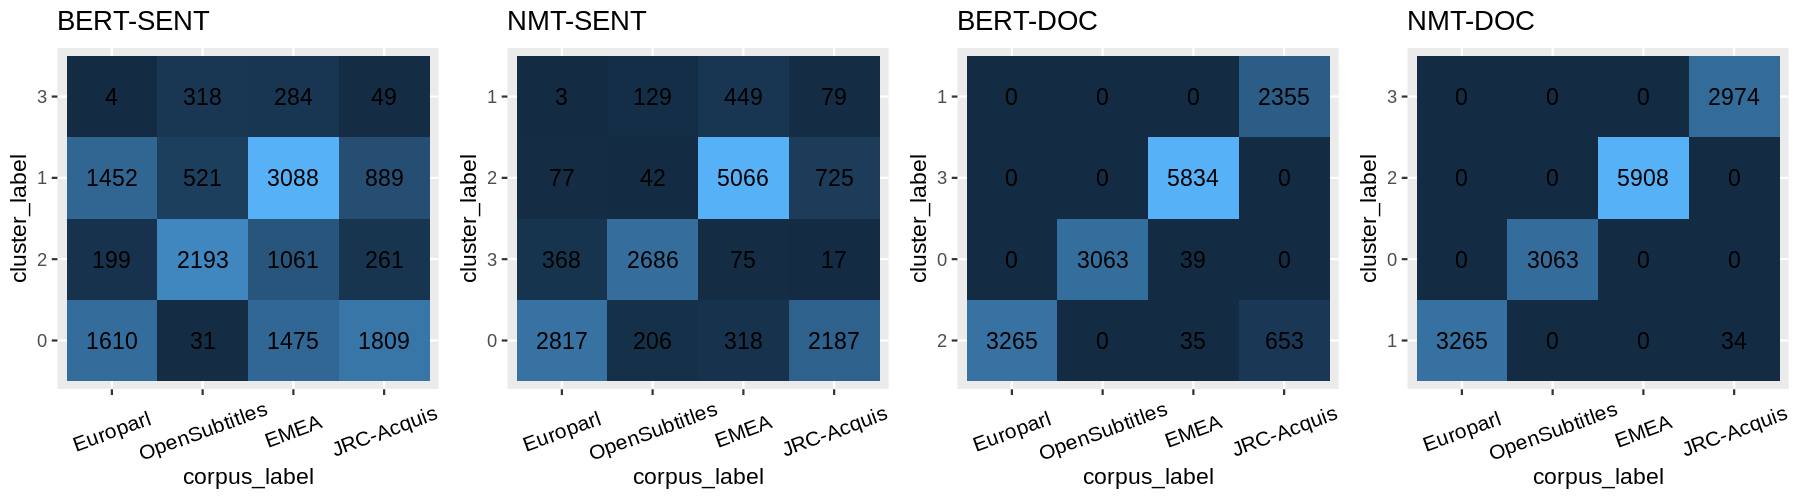

In [121]:
bp = "/home/maksym/normal-transformers/experiments/multidomain/automatic_domains/clusters-multidomain/clusters_de-en"
labels_pairs_dfs = compose_labels_pairs_dfs(bp)


# Plot
key = 'nmt-sent'

cat_clust_labels = CategoricalDtype(categories=['0', '3', '2', '1'], ordered=False)
cat_corpus_labels = CategoricalDtype(categories=['Europarl', 'OpenSubtitles', 'EMEA', 'JRC-Acquis'], ordered=False)

labels_pairs_dfs[key]['cluster_label'] = labels_pairs_dfs[key]['cluster_label'].astype(cat_clust_labels)
labels_pairs_dfs[key]['corpus_label'] = labels_pairs_dfs[key]['corpus_label'].astype(cat_corpus_labels)

# heatmap
#title = "Encoder: NMT  |  Level: sentence"#f"Interlingua at {all_interlingua_layerids} layers"
title = key.upper()
gp = ggplot2.ggplot(labels_pairs_dfs[key])
heatmap1 = gp \
+ ggplot2.aes_string(x='corpus_label', y='cluster_label', fill="count") \
+ ggplot2.ggtitle(title) \
+ ggplot2.geom_tile() \
+ ggplot2.geom_text(ggplot2.aes_string(label='count')) \
+ ggplot2.theme(legend_position = "none") +  ggplot2.theme(axis_text_x = ggplot2.element_text(angle = 20))



key = 'nmt-doc'

cat_clust_labels = CategoricalDtype(categories=['1', '0', '2', '3'], ordered=False)
cat_corpus_labels = CategoricalDtype(categories=['Europarl', 'OpenSubtitles', 'EMEA', 'JRC-Acquis'], ordered=False)

labels_pairs_dfs[key]['cluster_label'] = labels_pairs_dfs[key]['cluster_label'].astype(cat_clust_labels)
labels_pairs_dfs[key]['corpus_label'] = labels_pairs_dfs[key]['corpus_label'].astype(cat_corpus_labels)

# heatmap
#title = "Encoder: NMT  |  Level: sentence"#f"Interlingua at {all_interlingua_layerids} layers"
title = key.upper()
gp = ggplot2.ggplot(labels_pairs_dfs[key])
heatmap2 = gp \
+ ggplot2.aes_string(x='corpus_label', y='cluster_label', fill="count") \
+ ggplot2.ggtitle(title) \
+ ggplot2.geom_tile() \
+ ggplot2.geom_text(ggplot2.aes_string(label='count')) \
+ ggplot2.theme(legend_position = "none") +  ggplot2.theme(axis_text_x = ggplot2.element_text(angle = 20))


key = 'bert-sent'

cat_clust_labels = CategoricalDtype(categories=['0', '2', '1', '3'], ordered=False)
cat_corpus_labels = CategoricalDtype(categories=['Europarl', 'OpenSubtitles', 'EMEA', 'JRC-Acquis'], ordered=False)

labels_pairs_dfs[key]['cluster_label'] = labels_pairs_dfs[key]['cluster_label'].astype(cat_clust_labels)
labels_pairs_dfs[key]['corpus_label'] = labels_pairs_dfs[key]['corpus_label'].astype(cat_corpus_labels)

# heatmap
#title = "Encoder: NMT  |  Level: sentence"#f"Interlingua at {all_interlingua_layerids} layers"
title = key.upper()
gp = ggplot2.ggplot(labels_pairs_dfs[key])
heatmap3 = gp \
+ ggplot2.aes_string(x='corpus_label', y='cluster_label', fill="count") \
+ ggplot2.ggtitle(title) \
+ ggplot2.geom_tile() \
+ ggplot2.geom_text(ggplot2.aes_string(label='count')) \
+ ggplot2.theme(legend_position = "none") +  ggplot2.theme(axis_text_x = ggplot2.element_text(angle = 20))


key = 'bert-doc'

cat_clust_labels = CategoricalDtype(categories=['2', '0', '3', '1'], ordered=False)
cat_corpus_labels = CategoricalDtype(categories=['Europarl', 'OpenSubtitles', 'EMEA', 'JRC-Acquis'], ordered=False)

labels_pairs_dfs[key]['cluster_label'] = labels_pairs_dfs[key]['cluster_label'].astype(cat_clust_labels)
labels_pairs_dfs[key]['corpus_label'] = labels_pairs_dfs[key]['corpus_label'].astype(cat_corpus_labels)

# heatmap
#title = "Encoder: NMT  |  Level: sentence"#f"Interlingua at {all_interlingua_layerids} layers"
title = key.upper()
gp = ggplot2.ggplot(labels_pairs_dfs[key])
heatmap4 = gp \
+ ggplot2.aes_string(x='corpus_label', y='cluster_label', fill="count") \
+ ggplot2.ggtitle(title) \
+ ggplot2.geom_tile() \
+ ggplot2.geom_text(ggplot2.aes_string(label='count')) \
+ ggplot2.theme(legend_position = "none") +  ggplot2.theme(axis_text_x = ggplot2.element_text(angle = 20))





with grdevices.render_to_bytesio(grdevices.png, width=1800, height=500, res=150) as img:
    pp = cowplot.plot_grid(heatmap3, heatmap1, heatmap4, heatmap2, rows=1) 
    pp.plot() 
display(Image(data=img.getvalue(), format='png', embed=True))

# Evaluating layers

In [143]:
from collections import defaultdict
import numpy as np
from sklearn.cluster import KMeans
import scipy.stats as ss

from normal_transformers.util.util_data import pickle_load_from_file

In [152]:
def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

In [153]:
def prepare_reps(hiddens_dict):
    all_reps_prepared = defaultdict(lambda: list())
    all_labels = defaultdict(lambda: list())
    
    for dn, reps_all_layers in hiddens_dict.items():
        for layer_num, reps_layer in enumerate(reps_all_layers):
            all_reps_prepared[layer_num].extend(reps_layer)
            all_labels[layer_num].extend([dn] * len(reps_layer))
    
    for k, v in all_reps_prepared.items():
        all_reps_prepared[k] = np.array(v)
    
    for k, v in all_labels.items():
        all_labels[k] = np.array(v)
    
    return all_reps_prepared, all_labels

In [144]:
domain_names = ['Europarl', 'OpenSubtitles', 'EMEA', 'JRC-Acquis']

## XLM-R

In [260]:
bdir = "experiments/multidomain/four-domains-en_et/xlm-roberta-base/sentence_embeddings"

hiddens = {}
for dn in domain_names:
    fp = f"{bdir}/sentemb-mean-{dn}.pkl"
    hiddens[dn] = pickle_load_from_file(fp)
    
    

Loading from experiments/multidomain/four-domains-en_et/xlm-roberta-base/sentence_embeddings/sentemb-mean-Europarl.pkl
Loaded
Loading from experiments/multidomain/four-domains-en_et/xlm-roberta-base/sentence_embeddings/sentemb-mean-OpenSubtitles.pkl
Loaded
Loading from experiments/multidomain/four-domains-en_et/xlm-roberta-base/sentence_embeddings/sentemb-mean-EMEA.pkl
Loaded
Loading from experiments/multidomain/four-domains-en_et/xlm-roberta-base/sentence_embeddings/sentemb-mean-JRC-Acquis.pkl
Loaded


In [261]:
%%time

DOMAIN_NAMES = ["Europarl", "OpenSubtitles", "JRC-Acquis", "EMEA"]
NUM_LAYERS = 13


corr_ks = []

hiddens_reps, hiddens_labels = prepare_reps(hiddens)


for l in range(NUM_LAYERS):

    indices = np.arange(hiddens_reps[l].shape[0])
    np.random.shuffle(indices)

    hiddens_shuff = hiddens_reps[l][indices]
    labels_shuff = hiddens_labels[l][indices]

    kmeans = KMeans(n_clusters=4, random_state=0, n_init=10).fit(hiddens_shuff)

    conf_matrix = pd.crosstab(labels_shuff, kmeans.labels_)
    corr_k = cramers_corrected_stat(conf_matrix)
    corr_ks.append(corr_k)

    print(f"Layer {l} corr: {corr_k}")
    #print(conf_matrix)
    


Layer 0 corr: 0.37986197234219693
Layer 1 corr: 0.3616151776631274
Layer 2 corr: 0.37365730443999035
Layer 3 corr: 0.3758594046310442
Layer 4 corr: 0.3943573199144512
Layer 5 corr: 0.3832042524409476
Layer 6 corr: 0.37763601544746694
Layer 7 corr: 0.48866577933816757
Layer 8 corr: 0.4988736432461752
Layer 9 corr: 0.4700255698088904
Layer 10 corr: 0.3586753940298106
Layer 11 corr: 0.359813724434407
Layer 12 corr: 0.3627822894917145
CPU times: user 7min 37s, sys: 3min 55s, total: 11min 33s
Wall time: 36.8 s


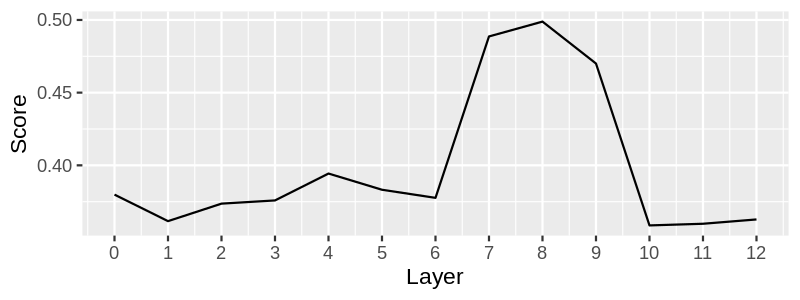

In [262]:
df_corr_ks_bert = pd.DataFrame.from_dict({"Layer": range(NUM_LAYERS), "Score": corr_ks})

with grdevices.render_to_bytesio(grdevices.png, width=800, height=300, res=150) as img:
    gp = ggplot2.ggplot(df_corr_ks_bert)
    pp = gp \
    + ggplot2.aes_string(x='Layer', y='Score') \
    + ggplot2.geom_line() \
    + ggplot2.scale_x_continuous(labels = df_corr_ks_bert["Layer"], breaks = df_corr_ks_bert["Layer"]) 
    pp.plot()
display(Image(data=img.getvalue(), format='png', embed=True))

## NMT 

In [250]:
bdir = "experiments/multidomain/four-domains-en_et/nmt-model/sentence_embeddings"

hiddens = {}
for dn in domain_names:
    fp = f"{bdir}/sentemb-mean-{dn}.pkl"
    hiddens[dn] = pickle_load_from_file(fp)
    

Loading from experiments/multidomain/four-domains-en_et/nmt-model/sentence_embeddings/sentemb-mean-Europarl.pkl
Loaded
Loading from experiments/multidomain/four-domains-en_et/nmt-model/sentence_embeddings/sentemb-mean-OpenSubtitles.pkl
Loaded
Loading from experiments/multidomain/four-domains-en_et/nmt-model/sentence_embeddings/sentemb-mean-EMEA.pkl
Loaded
Loading from experiments/multidomain/four-domains-en_et/nmt-model/sentence_embeddings/sentemb-mean-JRC-Acquis.pkl
Loaded


In [251]:
hiddens['Europarl'].shape

(14, 3001, 512)

In [252]:
%%time

DOMAIN_NAMES = ["Europarl", "OpenSubtitles", "JRC-Acquis", "EMEA"]
NUM_LAYERS = 14


corr_ks = []

hiddens_reps, hiddens_labels = prepare_reps(hiddens)


for l in range(NUM_LAYERS):

    indices = np.arange(hiddens_reps[l].shape[0])
    np.random.shuffle(indices)

    hiddens_shuff = hiddens_reps[l][indices]
    labels_shuff = hiddens_labels[l][indices]

    kmeans = KMeans(n_clusters=4, random_state=0, n_init=20).fit(hiddens_shuff)

    conf_matrix = pd.crosstab(labels_shuff, kmeans.labels_)
    corr_k = cramers_corrected_stat(conf_matrix)
    corr_ks.append(corr_k)

    print(f"Layer {l} corr: {corr_k}")
    print(conf_matrix)

Layer 0 corr: 0.47255721770021886
col_0             0    1     2     3
row_0                               
EMEA              1  133   673  2194
Europarl          5  272  1280  1444
JRC-Acquis        0  461  1113  1427
OpenSubtitles  1959    6    38   998
Layer 1 corr: 0.6001645202169786
col_0             0     1     2    3
row_0                               
EMEA            289    85  1795  832
Europarl        543  2323    97   38
JRC-Acquis      127  2122   289  463
OpenSubtitles  2564     0    82  355
Layer 2 corr: 0.7429304303896564
col_0             0     1     2     3
row_0                                
EMEA            663  2244    49    45
Europarl        486    33   184  2298
JRC-Acquis      353   288  2088   272
OpenSubtitles  2910    57     0    34
Layer 3 corr: 0.7636873363476855
col_0             0     1     2     3
row_0                                
EMEA           2300   639    29    33
Europarl         29   459  2345   168
JRC-Acquis      228   381   251  2141
OpenS

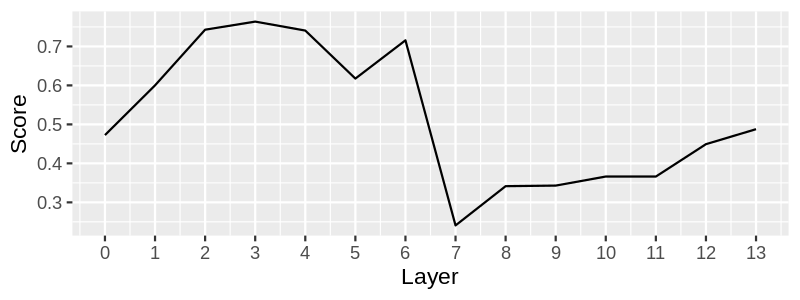

In [253]:
df_corr_ks_nmt = pd.DataFrame.from_dict({"Layer": range(NUM_LAYERS), "Score": corr_ks})

with grdevices.render_to_bytesio(grdevices.png, width=800, height=300, res=150) as img:
    gp = ggplot2.ggplot(df_corr_ks_nmt)
    pp = gp \
    + ggplot2.aes_string(x='Layer', y='Score') \
    + ggplot2.geom_line() \
    + ggplot2.scale_x_continuous(labels = df_corr_ks_nmt["Layer"], breaks = df_corr_ks_nmt["Layer"]) 
    pp.plot()
display(Image(data=img.getvalue(), format='png', embed=True))

# try to reproduce anyway; e.g. try paddint type==longest; at the very last copypaste code and do ablation study

Took the old sp data? 

#### Generation

In [238]:
bdir = "experiments/multidomain/four-domains-en_et/nmt-model/sentence_embeddings"

hiddens = {}
for dn in domain_names:
    fp = f"{bdir}/sentemb-mean-{dn}.pkl"
    hiddens[dn] = pickle_load_from_file(fp)
    

Loading from experiments/multidomain/four-domains-en_et/nmt-model/sentence_embeddings/sentemb-mean-Europarl.pkl
Loaded
Loading from experiments/multidomain/four-domains-en_et/nmt-model/sentence_embeddings/sentemb-mean-OpenSubtitles.pkl
Loaded
Loading from experiments/multidomain/four-domains-en_et/nmt-model/sentence_embeddings/sentemb-mean-EMEA.pkl
Loaded
Loading from experiments/multidomain/four-domains-en_et/nmt-model/sentence_embeddings/sentemb-mean-JRC-Acquis.pkl
Loaded


In [239]:
%%time

DOMAIN_NAMES = ["Europarl", "OpenSubtitles", "JRC-Acquis", "EMEA"]
NUM_LAYERS = 14


corr_ks = []

hiddens_reps, hiddens_labels = prepare_reps(hiddens)


for l in range(NUM_LAYERS):

    indices = np.arange(hiddens_reps[l].shape[0])
    np.random.shuffle(indices)

    hiddens_shuff = hiddens_reps[l][indices]
    labels_shuff = hiddens_labels[l][indices]

    kmeans = KMeans(n_clusters=4, random_state=0, n_init=20).fit(hiddens_shuff)

    conf_matrix = pd.crosstab(labels_shuff, kmeans.labels_)
    corr_k = cramers_corrected_stat(conf_matrix)
    corr_ks.append(corr_k)

    print(f"Layer {l} corr: {corr_k}")
    print(conf_matrix)

Layer 0 corr: 0.4777677017789821
col_0             0     1     2    3
row_0                               
EMEA              0  2509   689  150
Europarl          6  1813  1553  344
JRC-Acquis        0  1466  1082  457
OpenSubtitles  2019   972    46    7
Layer 1 corr: 0.596244246355513
col_0             0     1    2     3
row_0                               
EMEA           2012   344  918    74
Europarl        118   694   36  2868
JRC-Acquis      308   141  471  2085
OpenSubtitles    82  2616  346     0
Layer 2 corr: 0.7415241035037464
col_0             0     1     2     3
row_0                                
EMEA            758    53    40  2497
Europarl        637   220  2822    37
JRC-Acquis      361  2105   253   286
OpenSubtitles  2957     0    27    60
Layer 3 corr: 0.7611968255131059
col_0             0     1     2     3
row_0                                
EMEA             28    39   722  2559
Europarl       2876   207   603    30
JRC-Acquis      238  2155   389   223
OpenSub

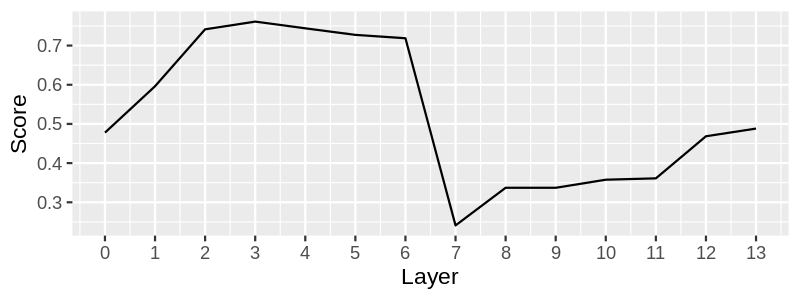

In [241]:
df_corr_ks_nmt = pd.DataFrame.from_dict({"Layer": range(NUM_LAYERS), "Score": corr_ks})

with grdevices.render_to_bytesio(grdevices.png, width=800, height=300, res=150) as img:
    gp = ggplot2.ggplot(df_corr_ks_nmt)
    pp = gp \
    + ggplot2.aes_string(x='Layer', y='Score') \
    + ggplot2.geom_line() \
    + ggplot2.scale_x_continuous(labels = df_corr_ks_nmt["Layer"], breaks = df_corr_ks_nmt["Layer"]) 
    pp.plot()
display(Image(data=img.getvalue(), format='png', embed=True))